In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
from arch import arch_model
import data_reader as dr
import metrics as mt

In [2]:
data, target = dr.read_data(window=22)
data.info()
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2406 non-null   object 
 1   Daily_trading_range  2406 non-null   float64
 2   Log_Volume_change    2406 non-null   float64
 3   Daily_return         2406 non-null   float64
 4   Daily_log_return     2406 non-null   float64
 5   Index                2406 non-null   float64
 6   oil                  2406 non-null   float64
dtypes: float64(6), object(1)
memory usage: 131.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384 entries, 0 to 2383
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2384 non-null   float64
dtypes: float64(1)
memory usage: 37.2 KB


In [3]:
target.tail()

,Target
2379,0.191057
2380,0.191888
2381,0.191501
2382,0.193158
2383,0.192272


In [4]:
split_index = int(len(data)*0.8)
print('Split index: ', split_index)
print('Observations: ', len(data))

Split index:  1924
Observations:  2406


In [5]:
def create_garch(data, target, p=1, q=1):
    logreturns = np.array(data[['Daily_log_return']])
    window = 22
    n_ahead = 1
    garch_pred = []
    for i in range(split_index-1, len(logreturns)-n_ahead):
        train = logreturns[:i]*100
        gm = arch_model(train, p=p, q=q)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    title = 'GARCH({},{}) prediction'.format(p, q)
    split_target = np.array(target.iloc[split_index-22:])
    plot(garch_pred, split_target, title, save=False)

    print('---------GARCH({},{}) estimation-----------'.format(p,q))
    mt.testScore(pred=garch_pred, target=split_target)

In [6]:
def create_gjr(data, target, p=1, q=1, o=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    window = 22
    gjr_pred = []
    for i in range(split_index-1, len(logreturns)-1):
        train = logreturns[:i] * 100
        gm = arch_model(train, p=p, q=q, o=o)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=1)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean()) * 0.01 * np.sqrt(252))

    title = 'GJR-GARCH({},{}) prediction'.format(p,q)
    split_target = np.array(target.iloc[split_index-22:])
    plot(gjr_pred, split_target, title, save=False)

    print('---------GJR-GARCH({},{}) estimation-----------'.format(p,q))
    mt.testScore(pred=gjr_pred, target=split_target)


In [7]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [8]:
logreturn = data[['Daily_log_return']]
logreturn

,Daily_log_return
0,0.007249
1,-0.001243
2,-0.002375
3,0.004126
4,-0.002587
...,...
2401,0.019042
2402,0.005812
2403,-0.006215
2404,0.009324


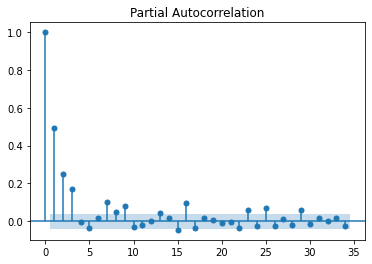

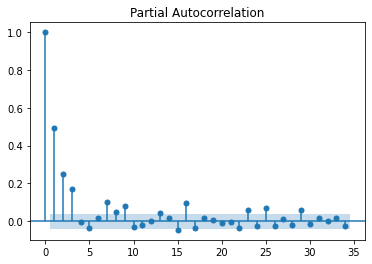

In [9]:
plot_pacf(logreturn**2)

In [10]:
for i in range(3):
    for j in range(3):
        gm_model = arch_model(logreturn*100, p=i+1,q=j+1)
        gjr_model = arch_model(logreturn*100, p=i+1, q=j+1, o=i+1)
        gm_fit = gm_model.fit(disp='off')
        gjr_fit = gjr_model.fit(disp='off')

        print('GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gm_fit.aic, gm_fit.bic))
        print('GJR-GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gjr_fit.aic, gjr_fit.bic))

GARCH(1,1) AIC, BIC: 6253.839 and 6276.982
GJR-GARCH(1,1) AIC, BIC: 6194.820 and 6223.748
GARCH(1,2) AIC, BIC: 6255.839 and 6284.768
GJR-GARCH(1,2) AIC, BIC: 6192.647 and 6227.362
GARCH(1,3) AIC, BIC: 6257.839 and 6292.554
GJR-GARCH(1,3) AIC, BIC: 6193.635 and 6234.135
GARCH(2,1) AIC, BIC: 6254.791 and 6283.719
GJR-GARCH(2,1) AIC, BIC: 6196.319 and 6236.819
GARCH(2,2) AIC, BIC: 6256.152 and 6290.866
GJR-GARCH(2,2) AIC, BIC: 6195.326 and 6241.612
GARCH(2,3) AIC, BIC: 6257.218 and 6297.718
GJR-GARCH(2,3) AIC, BIC: 6196.694 and 6248.765
GARCH(3,1) AIC, BIC: 6256.791 and 6291.505
GJR-GARCH(3,1) AIC, BIC: 6199.006 and 6251.077
GARCH(3,2) AIC, BIC: 6258.152 and 6298.652
GJR-GARCH(3,2) AIC, BIC: 6199.229 and 6257.087
GARCH(3,3) AIC, BIC: 6258.948 and 6305.234
GJR-GARCH(3,3) AIC, BIC: 6200.694 and 6264.337


/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


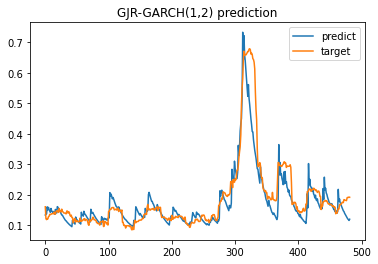

---------GJR-GARCH(1,2) estimation-----------
MSE Score: 0.0023112785971252407
RMSE Score: 0.04807575893446967
MAPE Score: 0.13705691195679137
MAE Score: 0.028196999779479114
---------GARCH(1,1) estimation-----------
MSE Score: 0.0013247040882408594
RMSE Score: 0.036396484558826
MAPE Score: 0.09968218517446663
MAE Score: 0.02055068792513436


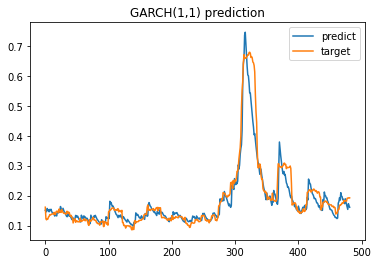

In [11]:
create_gjr(data, target, p=1,q=2)
create_garch(data, target, p=1,q=1)

## Results
| Models        | AIC        | BIC       |
| :------------ |:----------:| :---------:|
| **GARCH(1,1)**    | **6253.84**    | **6276.98**   |
| GARCH(1,2)    | 6255.84    | 6284.77   |
| GARCH(1,3)    | 6257.84    | 6292.55   |
| GARCH(2,1)    | 6254.79    | 6283.72   |
| GARCH(2,2)    | 6256.15    | 6290.87   |
| GARCH(2,3)    | 6257.22    | 6297.72   |
| GARCH(3,1)    | 6256.79    | 6291.51   |
| GARCH(3,2)    | 6258.15    | 6298.65   |
| GARCH(3,3)    | 6258.95    | 6305.23   |
| GJR-GARCH(1,1)    | 6194.82    | 6223.75   |
| **GJR-GARCH(1,2)**    | **6192.65**    | **6227.36**   |
| GJR-GARCH(1,3)    | 6193.64    | 6234.14   |
| GJR-GARCH(2,1)    | 6196.32    | 6236.82   |
| GJR-GARCH(2,2)    | 6195.33    | 6241.61   |
| GJR-GARCH(2,3)    | 6196.69    | 6248.77   |
| GJR-GARCH(3,1)    | 6199.01    | 6251.08   |
| GJR-GARCH(3,2)    | 6199.23    | 6257.09   |
| GJR-GARCH(3,3)    | 6200.69    | 6264.34   |